In [1]:
import os

from pathlib import Path

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import arviz as az

az.rcParams["data.load"] = "eager"

In [2]:
here = Path(os.path.realpath('.'))

root_dir = here.parent
collaterals_data_file = root_dir / "data" / "prepared" / "collaterals.csv"
mice_data_file = root_dir / "data" / "prepared" / "collaterals-mice.csv"
idata_dir = root_dir / "inferences" / "collaterals"

collaterals = pd.read_csv(collaterals_data_file)
mice = pd.read_csv(mice_data_file)
mice.head()

,Date,mouse_id,age,craniotomy_area,collaterals,collaterals_per_area,ln_collaterals_per_area
0,11020,11020,adult,6.312420,6,0.950507,-0.050760
1,40520,40520,adult,4.892264,5,1.022022,0.021783
2,41021,41021,old,7.024126,1,0.142366,-1.949351
3,50520,50520,old,6.257000,3,0.479463,-0.735089
4,51020,51020,adult,6.370858,6,0.941788,-0.059975


In [3]:
idata_ctls_per_area = az.from_netcdf(idata_dir / "ctls_per_area.nc")
az.summary(idata_ctls_per_area, var_names=["~sigma", "~mu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.127,0.074,-0.259,0.020,0.001,0.001,4850.0,2644.0,1.0
age[old],-0.481,0.203,-0.861,-0.088,0.004,0.003,3091.0,2688.0,1.0
sigma_Intercept,-0.938,0.139,-1.201,-0.692,0.002,0.002,3342.0,2466.0,1.0
sigma_age[old],0.567,0.230,0.167,1.027,0.004,0.003,3080.0,2453.0,1.0


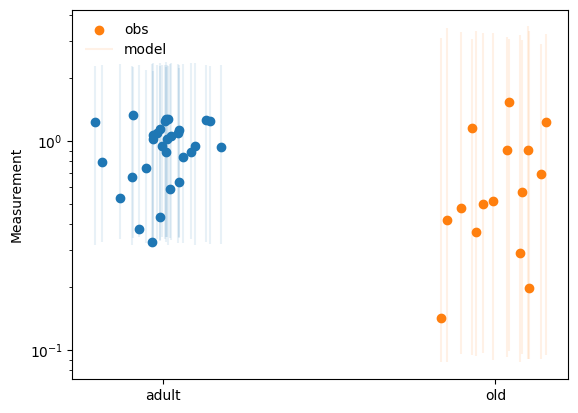

In [14]:
def plot_posterior_predictive(msts, idata, ycol):

    qlow, qhigh = (
        np.exp(idata.posterior_predictive["ln_" + ycol].quantile(q, dim=["chain", "draw"]).to_numpy())
        for q in [0.01, 0.99]
    )
    x = msts["age"].map({"adult": 0, "old": 1}) + np.random.normal(scale=0.1,size=len(msts))
    plot_df = msts.join(x.rename("x"))
    plot_df["qlow"] = qlow
    plot_df["qhigh"] = qhigh
    
    f, ax = plt.subplots()
    for age, subdf in plot_df.groupby("age"):
        sct = ax.scatter(subdf["x"], subdf[ycol]);
        color = sct.get_edgecolors()[0]
        vl = ax.vlines(subdf["x"], subdf["qlow"], subdf["qhigh"], color=color, alpha=0.1)
    ax.set_xticks([0, 1], ["adult", "old"])
    ax.set_ylabel("Measurement")
    ax.semilogy();
    ax.legend([sct, vl], ["obs", "model"], frameon=False, loc="upper left")
    return f, ax

f, ax = plot_posterior_predictive(mice, idata_ctls_per_area, "collaterals_per_area")

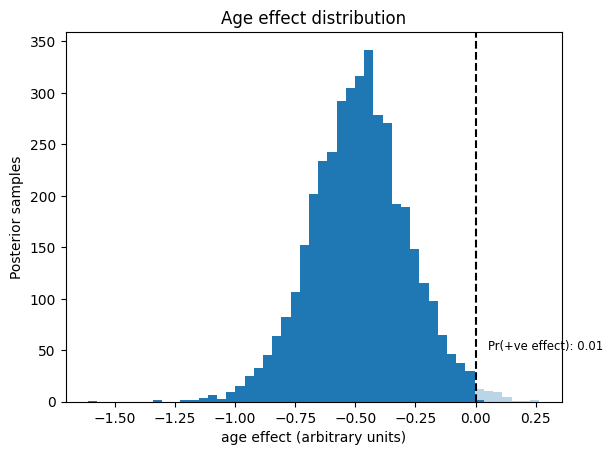

In [5]:
def plot_age_effect_samples(idata):

    age_effect_samples = idata.posterior["age"].to_numpy().flatten()
    tstat = (age_effect_samples > 0).mean()
    bins = np.linspace(age_effect_samples.min(), age_effect_samples.max(), 50)
    
    f, ax = plt.subplots()
    ax.hist(age_effect_samples[age_effect_samples < 0], bins=bins);
    ax.hist(age_effect_samples[age_effect_samples > 0], bins=bins, alpha=0.3, color="tab:blue");
    
    
    ax.axvline(0.0, linestyle="--", color="black");
    ax.text(0.05, 50, f"Pr(+ve effect): {tstat.round(2)}", fontsize="small");
    return f, ax

f, ax = plot_age_effect_samples(idata_ctls_per_area)
ax.set(
    xlabel="age effect (arbitrary units)",
    ylabel="Posterior samples",
    title="Age effect distribution"
);

ln_diameter_mean:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.018,0.024,2.971,3.063,0.000,0.000,6520.0,3216.0,1.0
age[old],0.028,0.049,-0.066,0.117,0.001,0.001,5436.0,3164.0,1.0


ln_curved_length:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,6.071,0.041,5.992,6.148,0.001,0.000,6374.0,3272.0,1.0
age[old],0.095,0.086,-0.073,0.252,0.001,0.001,5647.0,3326.0,1.0


ln_tortuosity:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.143,0.011,0.124,0.163,0.0,0.0,5875.0,3384.0,1.0
age[old],0.007,0.022,-0.032,0.052,0.0,0.0,5508.0,2875.0,1.0


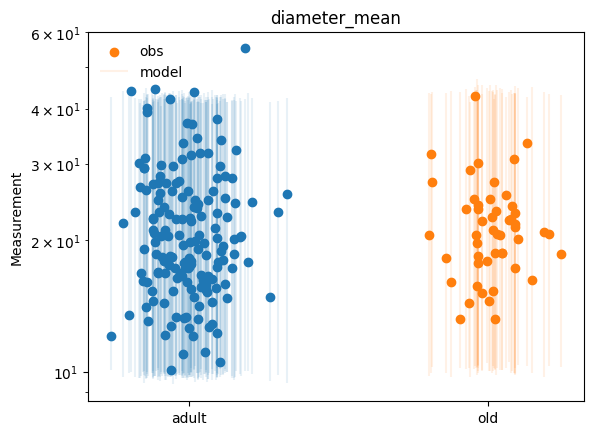

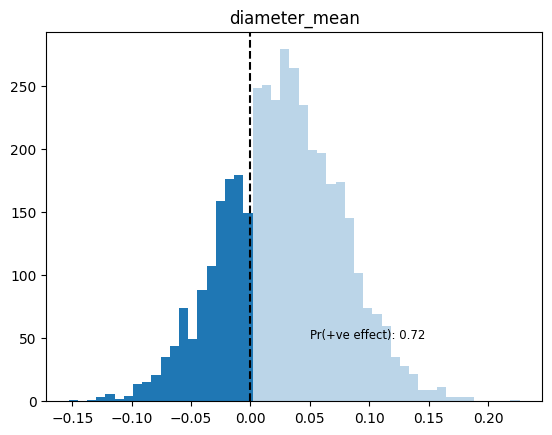

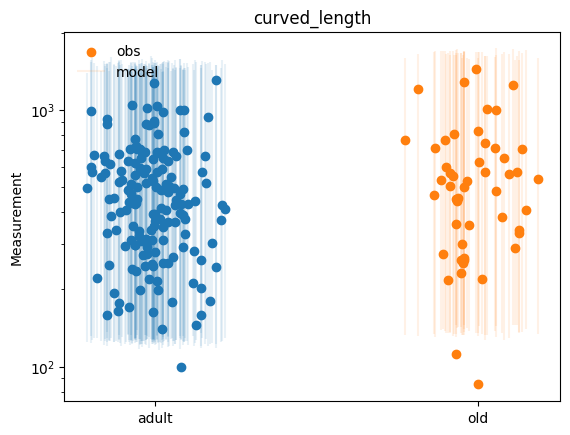

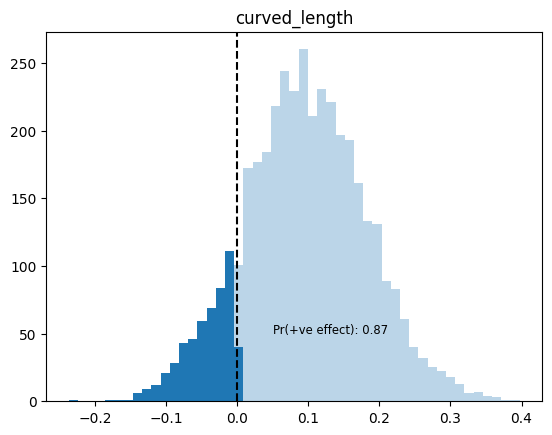

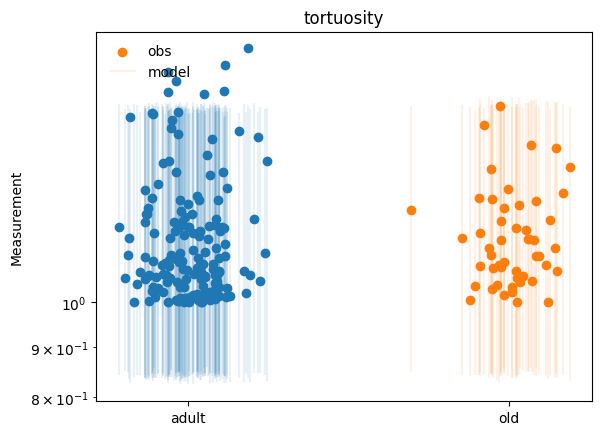

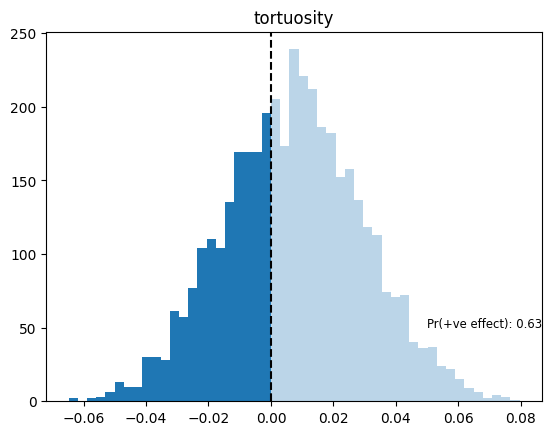

In [15]:
idatas_ctls = {
    ycol: az.from_netcdf(idata_dir / f"{ycol}.nc") 
    for ycol in ["ln_diameter_mean", "ln_curved_length", "ln_tortuosity"]
}

for ycol, idata in idatas_ctls.items():
    print(ycol + ":")
    display(az.summary(idata, var_names=["~sigma", "~mu"]))
    f, ax = plot_posterior_predictive(collaterals, idata, ycol[3:])
    ax.set(title=ycol[3:]);
    f, ax = plot_age_effect_samples(idata)
    ax.set(title=ycol[3:]);
